In [25]:
import torch, numpy as np, pickle as pkl, speachy, os
from typing import List, Dict, Tuple, Optional, Union
from importlib import reload as rl
from tqdm import tqdm
from speachy.utils.helpers import exists
from speachy.lm.models.qknorm_attention import transformer_lm
import time, heapq
from multiprocessing import Pool
import math
from functools import partial

[NeMo W 2023-03-02 09:50:06 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-03-02 09:50:06 experimental:27] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [35]:
from einops import rearrange, repeat

In [36]:
class argsclass():
    def __init__(self, args:Dict): self.__dict__.update(args)

In [37]:
!ls ../checkpoints/open_sub_ft_ami/

128subword_ami_opensub_802_78.pt  checkpoint_809_id_37.pt  old	other


In [38]:
config = speachy.utils.general.load_config('../experiment_configs/lm/decoder_pg19_sep_token_ami.yaml')
tokenizer_path = '.'+os.path.join(config['model']['tokenizer']['dir'], 'tokenizer.model')
tokenizer = speachy.utils.general.load_tokenizer(tokenizer_path)
lm_model = speachy.lm.tools.loading.autoload(config=config, tokenizer=tokenizer)
_,_ = speachy.utils.general.load_checkpoint(
    args = argsclass({'checkpoint':'../checkpoints/open_sub_ft_ami/128subword_ami_opensub_802_78.pt'}),
    model = lm_model,
    force_cpu = True
)

../checkpoints/open_sub_ft_ami/128subword_ami_opensub_802_78.pt
odict_keys(['sep_token', 'layers.temperature', 'layers.positional_bias.mlp.0.0.weight', 'layers.positional_bias.mlp.0.0.bias', 'layers.positional_bias.mlp.1.0.weight', 'layers.positional_bias.mlp.1.0.bias', 'layers.positional_bias.mlp.2.weight', 'layers.positional_bias.mlp.2.bias', 'layers.layers.0.0.norm.weight', 'layers.layers.0.0.norm.bias', 'layers.layers.0.0.fn.temperature', 'layers.layers.0.0.fn.q_proj.weight', 'layers.layers.0.0.fn.kv_proj.weight', 'layers.layers.0.0.fn.out_proj.weight', 'layers.layers.0.1.norm.weight', 'layers.layers.0.1.norm.bias', 'layers.layers.0.1.fn.0.proj.weight', 'layers.layers.0.1.fn.0.proj.bias', 'layers.layers.0.1.fn.2.weight', 'layers.layers.0.1.fn.2.bias', 'layers.layers.1.0.norm.weight', 'layers.layers.1.0.norm.bias', 'layers.layers.1.0.fn.temperature', 'layers.layers.1.0.fn.q_proj.weight', 'layers.layers.1.0.fn.kv_proj.weight', 'layers.layers.1.0.fn.out_proj.weight', 'layers.layers.1.

okay everybody finish place again yeah that's nice okay so this is a second meeting and uh still failing

Decoded: okay everybody finish place again yeah that's nice so this is the second meeting and uh still failing

Targets: okay everybody found his place again yeah that's nice okay so this is our second meeting and uh still failing


In [30]:
!ls *.pkl

log_probs.pkl  lps.pkl	lps_s.pkl


In [39]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pkl_data = pkl.load(f)
    return pkl_data['stage'], pkl_data['data']

def load_pickle_normal(path):
    with open(path, 'rb') as f:
        pkl_data = pkl.load(f)
    return pkl_data

In [40]:
stage, data = load_pickle('../ami/tmp/dev_ami.pkl')

In [33]:
data = load_pickle_normal('../ami/tmp/dev_ami.pkl')

In [34]:
data[3]

KeyError: 3

In [ ]:
!ls ../ami/tmp/

dev_ami_n_____.pkl  dev_ami.pkl  dev_tmp_ami_____.pkl


E0301 21:49:57.330847375   68662 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


In [ ]:
data[0]['probs'].shape

In [ ]:
!ls ../ami/tmp

dev_  dev_ami_n_____.pkl  _devBEAM.pkl	dev_tmp_ami_____.pkl


In [ ]:
with open('log_probs.pkl', 'rb') as f:
    log_probs = pkl.load(f).to('cpu')[None]
print(log_probs.shape)

torch.Size([1, 5, 410, 129])


In [ ]:
log_probs.shape[-1]-1


128

In [ ]:
lm_model.sep_token.shape

torch.Size([1, 256])

In [41]:
class Beam():
    def __init__(
        self, 
        state,
        am_sequence = [],
        lm_sequence = [],
        next_lm_token_lps = None,
        score = 0,
    ):
        self.state = state #{k:v.clone() for k,v in state.items()}
        self.score = score
        self.am_sequence = am_sequence
        self.lm_sequence = lm_sequence
        self.next_lm_token_lps = next_lm_token_lps

    def __str__(self):
        return f"{self.am_sequence}"

    def __repr__(self):
        return self.__str__()


In [42]:
class Beam():
    def __init__(
        self, 
        state,
        am_sequence = [],
        lm_sequence = [],
        next_lm_token_lps = None,
        past_scores = [],
        score = 0,
    ):
        self.state = state 
        self.past_scores = past_scores
        self.score = score
        self.am_sequence = am_sequence
        self.lm_sequence = lm_sequence
        self.next_lm_token_lps = next_lm_token_lps

    def __str__(self):
        return f"{self.am_sequence}"

    def __repr__(self):
        return self.__str__()


class LanguageModel():
    def __init__(
        self, 
        model:transformer_lm, 
        bos_id=0, 
        device='cpu', 
        temperature=1.0,
        half_precision=False,
        keep_states_on_device=True,
    ):
        self.model = model
        self.model.eval()
        self.bos_id = bos_id
        self.device = torch.device(device)
        self.model.to(self.device)
        self.half = half_precision
        if self.half:
            self.model.half()
        self.temperature = temperature
        self.offload_device = self.device if keep_states_on_device else 'cpu'
        assert self.bos_id == 0, "written assuming bos_id is 0 ):"
    
    def logits_to_lprobs(self,logits):
        logits = logits[:,:,1:] / self.temperature if self.temperature != 1.0 else logits[:,:,1:] 
        return logits.log_softmax(dim=-1)

    @torch.no_grad()
    def get_initial_state(self):
        x, length = torch.tensor([[self.bos_id]]).to(self.device), torch.LongTensor([1]).to(self.device)
        logits, _, state = self.model(x=x, length=length)
        return self.logits_to_lprobs(logits).squeeze().to('cpu'), {k:v.to(self.offload_device) for k,v in state.items()}

    @staticmethod
    def move_to_device(input_ids, input_lengths, states, device):
        input_ids, input_lengths = input_ids.to(device), input_lengths.to(device)
        states = {k:v.to(device) for k,v in states.items()} if exists(states) else None
        return input_ids, input_lengths, states

    @torch.no_grad()
    def apply_sep_token(self, beams): # update all beams with a seperator (used in-between utterances)
        L, KV, _, H, N, D = beams[0].state['cache'].shape
        B = len(beams)
        assert B > 0, "no beams to apply sep token to ):"
        states, state_lens = [], []
        for beam in beams: 
            states.append(rearrange(beam.state['cache'], 'l kv b h n d -> n (l kv b h) d')) # so we can use rnn.pad_sequence
            state_lens.append(beam.state['cache_lengths'])
        states = torch.nn.utils.rnn.pad_sequence(states, batch_first=True, padding_value=0)
        states = rearrange(states, 'nb n (l kv b h) d -> l kv (b nb) h n d', l=L, kv=KV, h=H, d=D)
        state_lens = torch.cat(state_lens, dim=0)
        cache = {'cache': states, 'cache_lengths': state_lens}
        cache = {k:v.to(self.device) for k,v in cache.items()}

        assert hasattr(self.model, 'sep_token'), "model does not have sep_token attribute"
        sep_token = self.model.sep_token
        sep_token = repeat(sep_token, '() d -> b n d', b=B, n=1)

        sep_token = sep_token.to(self.device)
        length = repeat(torch.LongTensor([1]), '() -> b', b=B).to(self.device)
        if self.half:
            sep_token = sep_token.half()
        _, _, cached_kvs = self.model.layers(x=sep_token, length=length, cache=cache)
        cached_kvs = {k:v.to(self.offload_device) for k,v in cached_kvs.items()}
        for i, beam in enumerate(beams):
            beam.state = {
                'cache': cached_kvs['cache'][:,:,i, None], 
                'cache_lengths': cached_kvs['cache_lengths'][i, None],
                'next_sentence_pred': beam.state['next_sentence_pred']
            }
        return beams


    @torch.no_grad()
    def __call__(self, input_ids, input_lengths, states=None):
        input_ids, input_lengths, states = self.move_to_device(input_ids, input_lengths, states, self.device)
        logits, _, new_state = self.model(x=input_ids, length=input_lengths, cache=states)
        return self.logits_to_lprobs(logits).to('cpu'), {k:v.to(self.offload_device) for k,v in new_state.items()}

In [43]:
(torch.randn(10)/0.000001).softmax(-1)

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
beam_search.language_model.model.next_sentence_pred

AttributeError: 'transformer_lm' object has no attribute 'next_sentence_pred'

In [52]:
#TODO: vectorise adding scores X (not necessary for now)
#TODO: (BIGGEST SLOW DOWN) remove list cloning and appending and only keep track of last character + string
#TODO: cut off at cettain log p difference from best beam
#TODO: cache all states at each timestep for beams in top k / threshold to avoid recomputing
#TODO: convert LM to onnx or torchscript
class BeamSearch(): 
    def __init__(
            self, 
            tokenizer, 
            beam_width, 
            log_probs, 
            language_model: LanguageModel,
            alpha=0.4, # score = am + lm*alpha + beta if not blank or repitition else am
            beta=0.4, # beta offsets for lack of blank and repitition in lm probs
            blank_id=128,
            blank_penalty=0.0, # additional penalty for blank
            repitition_penalty=0.0, # additional penalty for repitition
            top_am_threshold=40, # top am scores to consider
            max_cache_length = -1, # max length of cache to keep in memory
            debug=False
        ):
        self.tokenizer = tokenizer
        self.beam_width = beam_width
        self.vocab_size = tokenizer.vocab_size
        self.log_probs = log_probs
        self.language_model = language_model
        self.blank_id = blank_id
        self.alpha = alpha
        self.beta = beta
        self.beams = []
        self.position = 0 # position in sequence
        self.blank_penalty = blank_penalty
        self.max_cache_length = max_cache_length
        self.repitition_penalty = repitition_penalty
        self.top_am_threshold = top_am_threshold
        self.debug = debug
        self.total_in_windows = []

    def initiate(self):
        assert len(self.beams) == 0 and self.position == 0, 'initiate can only be called once | beams should be empty'
        lm_logps, state = self.language_model.get_initial_state()
        self.beams = [
            Beam(
                state = state,
                am_sequence = [None], # no bos for am
                lm_sequence = [self.language_model.bos_id], # bos for lm
                next_lm_token_lps = lm_logps, # log probs of next token
            )
        ]


    def return_text(self, idx):
        if idx >= len(self.beams):
            print('Beam index out of range')
            return
        beam = self.beams[idx]
        return self.tokenizer.ids_to_text(beam.lm_sequence[1:])


    def print_beams(self):
        for i, beam in enumerate(self.beams):
            print(f'{i}: {self.return_text(i)} | {beam.score}')

    def prune(self, beams):
        print(f'Num beams to sort: {len(beams)}') if self.debug else None
        beams = heapq.nlargest(self.beam_width, beams, key=lambda beam: beam.score) # faster than sort
        return beams

    @staticmethod
    def _sum_log_scores(s1:float, s2:float) -> float:
        return s1+math.log(1+math.exp(s2-s1)) if s1>=s2 else s2+math.log(1+math.exp(s1-s2))

    def merge(self, beams):
        self.beam_dict = {}
        for beam in beams:
            beam_str = str(beam)
            if beam_str in self.beam_dict:
                self.beam_dict[beam_str].score = self._sum_log_scores(beam.score, self.beam_dict[beam_str].score)
            else:
                self.beam_dict[beam_str] = beam
        return list(self.beam_dict.values())

    def next_utterance(self, new_log_probs):
        ''' update beams with new utterance (next utterance in a dialogue)'''
        self.log_probs = new_log_probs
        self.position = 0 # reset position
     
        for beam in self.beams:
            beam.next_lm_token_lps = self.language_model.logits_to_lprobs(
                beam.state['next_sentence_pred'].squeeze()[None,None,:]
            ).squeeze()
            #print(beam.next_lm_token_lps.shape)
        self.language_model.apply_sep_token(beams=self.beams)


            
    @staticmethod
    def trim_cache(state, new_length):
        bos = state['cache'][:, :, :, :, 0, :].unsqueeze(-2).clone()
        amount_to_trim = state['cache_lengths'][-1] - new_length
        state['cache'] = state['cache'][:, :, :, :, amount_to_trim:, :]
        state['cache'] = torch.cat([bos, state['cache']], dim=-2)
        state['cache_lengths'] = state['cache_lengths'] - amount_to_trim + 1 # add bos
        return state

    def grab_state(self, state, indice):
        ## TODO: trim cache to be equal to cache_lengths
        cache_len = state['cache_lengths'][indice]
        cache = {
            'cache': state['cache'][:,:,indice, None], 
            'cache_lengths': state['cache_lengths'][indice, None],
            'next_sentence_pred': state['next_sentence_pred'][indice],
        }
        if self.max_cache_length == -1 or cache_len <= self.max_cache_length:
            return cache
        else:
            return self.trim_cache(cache, self.max_cache_length)

    def run_search(self, use_tqdm=True):
        search = True
        pbar = tqdm(total=len(self.log_probs)) if use_tqdm else None
        pbar.update(self.position) if use_tqdm else None
        while search:
            search = self.step()
            pbar.update(1) if use_tqdm else None
        pbar.close() if use_tqdm else None

    def step(self):
        if self.position == len(self.log_probs):
            return False
        if self.position == 0 and len(self.beams) == 0:
            self.initiate()

        # now create new beams
        new_beams = []
        stime = time.time()
        cur_am_lgps = self.log_probs[self.position]
        
        # only look at top k am scores 
        #top_am_indices = torch.topk(cur_am_lgps, self.top_am_threshold, dim=0, sorted=False, largest=True).indices
        top_am_indices = torch.arange(cur_am_lgps.shape[-1])[(cur_am_lgps > (cur_am_lgps[cur_am_lgps.argmax()] + self.top_am_threshold))]
        
        for beam in self.beams: # this is main bottleneck
            beam_lm_probs = beam.next_lm_token_lps
           
                
            #beam_lm_probs[top_am_indices-1] = torch.nn.functional.log_softmax(beam_lm_probs[top_am_indices-1], dim=-1)
            beam_lm_probs = beam_lm_probs * self.alpha + self.beta
            #joint_am_lm_probs = (beam_lm_probs + cur_am_lgps[1:-1]) # joint_am_lm_probs[i-1] + beam.score
           
            for i in range(1, self.vocab_size+1):
                if i not in top_am_indices:
                    continue

                b_am_seq, b_lm_seq = beam.am_sequence, beam.lm_sequence
                #stime = time.time()
                if b_am_seq[-1] == i or i == self.blank_id: # won't need scoring from language model
                    new_beam = Beam(
                        state = beam.state,
                        am_sequence = b_am_seq + [i] if i == self.blank_id and b_am_seq[-1] != self.blank_id else b_am_seq,
                        lm_sequence = b_lm_seq,
                        next_lm_token_lps = beam.next_lm_token_lps,
                        past_scores= beam.past_scores,
                        score = self.log_probs[self.position][i] + beam.score + (self.blank_penalty if i == self.blank_id else self.repitition_penalty)
                    )
                else:
                    new_beam = Beam(
                        state = beam.state,
                        am_sequence = b_am_seq + [i] if b_am_seq[-1] != self.blank_id else b_am_seq[:-1] + [i], # remove blank if it is followed by a non blank
                        lm_sequence = b_lm_seq + [i], 
                        next_lm_token_lps = None, # will be updated in next step
                        past_scores= beam.past_scores + [beam_lm_probs[i-1]],
                        score = self.log_probs[self.position][i] + beam_lm_probs[i-1] + beam.score
                    )

                   
             
                new_beams.append(new_beam)
    
           
        etime = time.time()
        print('beam time', etime - stime) if self.debug else None

        
        new_beams = self.merge(new_beams)
        new_beams = self.prune(new_beams)

        if self.position == len(self.log_probs) - 1: # exit if we are at the end 0:
            self.beams = new_beams
            return False
        
        states, state_lens, sequences, sequence_lens = [], [], [], []
        
        # Layer, Key+Value, Batch, Head, Sequence, Dimension
     
        for beam in new_beams: # already fast
            if beam.next_lm_token_lps is None:
                states.append(rearrange(beam.state['cache'], 'l kv b h n d -> n (l kv b h) d')) # so we can use rnn.pad_sequence
                #print(states[-1].shape, beam.state['cache'].shape)
                sequences.append(torch.tensor(beam.lm_sequence[-1]))
                sequence_lens.append(1)
                state_lens.append(beam.state['cache_lengths'])
    

        if len(sequences) != 0:
            L, KV, _, H, N, D = new_beams[0].state['cache'].shape
            stime = time.time()
            states = torch.nn.utils.rnn.pad_sequence(states, batch_first=True, padding_value=0)
            states = rearrange(states, 'nb n (l kv b h) d -> l kv (b nb) h n d', l=L, kv=KV, h=H, d=D)
            sequences = torch.stack(sequences, dim=0)[:, None]
            sequence_lens = torch.LongTensor(sequence_lens)
            states = {'cache': states, 'cache_lengths': torch.cat(state_lens, dim=0)}

            stime = time.time()
            print(f'batch size: {sequences.shape[0]}') if self.debug else None
            logps, states = self.language_model(input_ids=sequences, input_lengths=sequence_lens, states=states)
            logp_idx = 0
            for beam in new_beams:
                if beam.next_lm_token_lps is None:
                    beam.next_lm_token_lps = logps[logp_idx][-1]
                    beam.state = self.grab_state(states, logp_idx)
                    logp_idx += 1
        
            etime = time.time()
            print('LM time: ', etime-stime) if self.debug else None

        self.beams = new_beams
        self.position += 1
        return True

In [ ]:
import ray
ray.shutdown()
ray.init(num_cpus=20, num_gpus=1)

2023-03-01 21:46:12,216	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.8.13
Ray version:,2.2.0


In [ ]:
@ray.remote(num_gpus=0.25, num_cpus=1)
def run_search(beam_fn, logps):
    search = beam_fn(log_probs=logps)
    search.run_search(use_tqdm=False)
    return search.return_text(0)

In [ ]:
beamsearch_fn = partial(
    BeamSearch, 
    language_model=LanguageModel(model=lm_model, bos_id=0, device='cuda:0'), 
    tokenizer=tokenizer, 
    beam_width=10,
    beta=0.5,
    alpha=0.4,
    blank_id=128,
    blank_penalty=0.0,
    repitition_penalty=0.0,
    top_am_threshold=5,
    debug=False
)
beamsearch_fn = ray.put(beamsearch_fn)

NameError: name 'ray' is not defined

In [ ]:
result_text = [run_search.remote(beamsearch_fn, log_probs[0][0]) for i in range(8)]
output = ray.get(result_text)
print(output)

In [ ]:
result_text = [run_search.remote(beamsearch_fn, data[i]['probs']) for i in range(20)]
output = ray.get(result_text)
print(output)

['', "it's not saved yet", 'okay', 'so', "'", 'or beautiful drawing', 'so just', "so this is our agenda you you're going to show your prototype presentation after me", 'oops', '', "oh i didn't know he", 'so these are the', 'oh okay yeah', "so these are the last notes that are made if anything doesn't look right just say it to me and i don't have to put it in the report", "you know we're doing the speech recognition because we didn't have enough time to um design the inside as well", "okay but still possible uh uh financially so if you want to it's okay", "okay yeah but then then we're gonna put it in", 'okay just', 'yeah just so we have to design the inside then but it should be a', "or are we making a slide open like underneath or fall open i don't know"]


In [ ]:
output

['',
 "it's not saved yet",
 'okay',
 'so',
 "'",
 'or beautiful drawing',
 'so just',
 "so this is our agenda you you're going to show your prototype presentation after me"]

In [ ]:
[i for i, el in enumerate(data) if el['targets'][0]=="if i can con we are pirette the two marianne and i are receivi and maggie and susan are receiving a lot of student so we"]

[1312]

In [ ]:
el  =data[idx]['probs'].log()[10]

In [ ]:
torch.arange(el.shape[-1])[(el > (el[el.argmax()] - 7))]

tensor([ 20,  92, 105, 108, 122, 128])

In [ ]:
data[0]['probs'].shape

torch.Size([362, 129])

In [53]:
idx = 0
#data[idx]['probs']
#data[0]['probs'].shape[-1]-1
beam_search = BeamSearch(
    tokenizer=tokenizer,
    beam_width=25,
    log_probs=data[idx]['probs'],
    language_model=LanguageModel(model=lm_model, bos_id=0, device='cpu'),
    alpha=0.4,
    beta=0.5,
    blank_id=data[0]['probs'].shape[-1]-1,
    blank_penalty=0.0,
    repitition_penalty=0.0,
    top_am_threshold=-6, # limit search to top k AM scores
    max_cache_length=-1,
    debug=False
)
#print(data[idx]['targets'][0])

but is it' the battery yeah there are some things that they didn't mentioned because recharges not on the list but okay so i think we are pretty much in the right direction because it's twelve point three euros so

In [ ]:
beam_search.language_model.apply_sep_token(beams=beam_search.beams)

In [ ]:
total_lst = []

In [89]:
beam_search.run_search()

100%|██████████| 279/279 [00:26<00:00, 10.53it/s]


In [ ]:
beam_search.print_beams()

In [ ]:
beam_search.beams[1].past_scores

In [56]:
def EMA(a, alpha=0.99):
    b = a.clone()
    for i in range(1, len(a)):
        b[i] = alpha * b[i-1] + (1-alpha) * a[i]
    return b

In [88]:
beam_search.next_utterance(new_log_probs=data[6]['probs'])

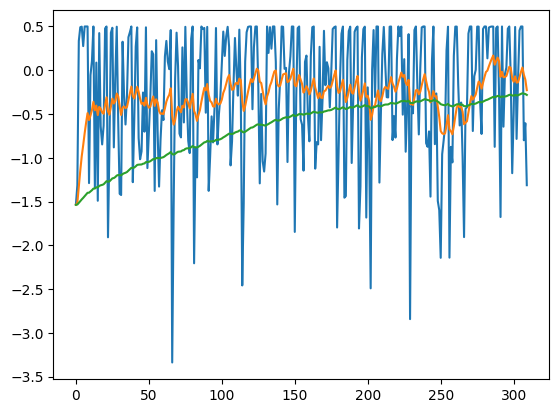

In [97]:
import matplotlib.pyplot as plt
past_scores = beam_search.beams[0].past_scores
past_scores = torch.stack(past_scores, dim=0)
plt.plot(past_scores)
plt.plot(EMA(past_scores,alpha=0.9))
plt.plot(EMA(past_scores,alpha=0.99))

0: okay yeah but then then we gonna put it in | 58.046207427978516

In [ ]:
beam_search = BeamSearch(
    tokenizer=tokenizer,
    beam_width=1,
    log_probs=data[idx]['probs'].log(),
    language_model=LanguageModel(model=lm_model, bos_id=0, device='cuda:0'),
    alpha=0.0,
    beta=0.0,
    blank_id=data[0]['probs'].shape[-1]-1,
    blank_penalty=0.0,
    repitition_penalty=0.0,
    num_workers=10,
    top_am_threshold=128, # limit search to top k AM scores
    debug=False
)
beam_search.run_search()
beam_search.print_beams()

100%|██████████| 325/325 [00:00<00:00, 582.00it/s]

0: so recept some pafle | -10.228267669677734


In [ ]:
beam_search.run_search()
beam_search.print_beams()

100%|██████████| 134/134 [00:03<00:00, 35.77it/s]

0: okay but still possible to uh stop uh s financially so if you want to s it's okay i'm | 145.2178192138672
1: okay but still possible to uh stop uh s financially so if you want to s it's okay i'll | 145.20993041992188
2: okay but still possible to uh stop uh s financially so if you want to s it's okay i' | 144.73741149902344
3: okay but still possible to uh stop uh s financially so if you want to s it's okay i'm | 144.21363830566406
4: okay but still possible to uh stop uh s financially so if you want to s it's okay i'll | 144.20574951171875


In [ ]:
beam_search.print_beams()

0:  | 10.152697563171387
1: no | 8.721010208129883
2: he | 8.619531631469727
3: i | 7.763772964477539
4: oh | 7.741393566131592
5: h | 7.505728721618652
6: n | 7.36505126953125
7: o | 6.318929672241211
8: oh | 5.720912933349609
9: nop | 2.261976718902588


In [ ]:
beam_search.step()
beam_search.print_beams()
        

0:  | 0.999812662601471
1: i | -2.251192331314087
2:  | -5.278331756591797
3: uh | -7.186532497406006
4: mm | -8.113367080688477


In [ ]:
import sys

In [ ]:
el_size = beam_search.beams[3].state['cache'].contiguous().element_size()
n_elements = beam_search.beams[3].state['cache'].contiguous().nelement() 
print(f"Size of the tensor: {n_elements * el_size / 1024 / 1024} MB")

Size of the tensor: 0.7060546875 MB


In [ ]:
beam_search.beams[1]

[None, 74, 75, 123, 23, 112, 119, 103, 114, 112, 27, 13, 68, 105, 34, 111, 104, 116, 101, 4, 117, 104, 13, 25, 128]

In [ ]:
beam_search.print_beams()

0: okay everybody finish place again | -46.99462890625
1: okay everybody finish place again yeah | -47.771907806396484
2: okay everybody finish place again n | -50.726444244384766
3: okay everybody finish place again y | -54.025733947753906
4: okay everybody finish placed again | -54.676918029785156
5: okay everybody finish place again that | -54.79623031616211
6: okay everybody fish place again | -55.57752990722656
7: everybody finish place again | -55.94749450683594
8: okay everybody fish place again yeah | -57.06871795654297
9: okay everybody finish place again now | -57.804744720458984


In [ ]:
beam_search.print_beams()

okay everybody finish place again yeah that's nice okay so this is the second meeting and uh still failing yes yeah and now we're going into the functional design um important thing of this phase is that we're going to uh try to get a agreement about the user requirements technical function design and the working design so that we can move on to the second uh phase but first this phase um first announcement there's a little adaptation in the arconditioning system so -481.4631042480469
okay everybody finish place again yeah that's nice okay so this is the second meeting and uh still failing yes yeah uh now we're going into the functional design um important thing of this phase is that we're going to uh try to get a agreement about the user requirements technical function design and the working design so that we can move on to the second uh phase but first this phase um first announcement there's a little adaptation in the arconditioning system so -481.6800231933594
okay everybody finish

In [ ]:
beam_search.print_beams()

okay everybody finish place again yeah that's nice okay so this is the second meeting and uh still fairly yes yeah uh now we're going um into the functional design um important thing of this phase is that we're going to uh try to get a agreement about the user requirements technical functional design and the working design so that we can move on to the second uh phase but first this phase um first advancement there's a little adaptation in the ear conditioning system so 51.85634994506836
okay everybody finish place again yeah that's nice okay so this is the second meeting and uh still fairly yes yeah uh now we're going um into the functional design um important thing of this phase is that we're going to uh try to get a agreement about the user requirements technical function design and the working design so that we can move on to the second uh phase but first this phase um first advancement there's a little adaptation in the ear conditioning system so 51.78715896606445
okay everybody f

In [ ]:
beam_search.print_beams()

okay everybody finish place again yeah that's nice okay so this is the second meeting and uh still failing yes yeah uh now we're going into the functional design um important thing of this phase is that we're going to uh try to get a agreement about the user requirements technical functional design and the working design so that we can move on to the second uh phase but first this phase um first announcement there's a little adaptation in the ear conditioning system so -40.32543182373047
okay everybody finish place again yeah that's nice okay so this is the second meeting and uh still failing yes yeah and now we're going into the functional design um important thing of this phase is that we're going to uh try to get a agreement about the user requirements technical functional design and the working design so that we can move on to the second uh phase but first this phase um first announcement there's a little adaptation in the ear conditioning system so -40.338409423828125
okay everybo

Decoded: yeah if we if we make a remote control just like with that idea in mind we could make does a money i think we don't have to focus on on on the on the design then but on functionality we just

Targets: yeah if we if we make a remote control just l with that idea in mind we could make tons of money i think we don't have to focus on on on the on the design then but on functionality we just



In [ ]:
beam_search.print_beams()

In [ ]:
7.200241088867188e-05*256*100*300

552.978515625

In [ ]:
0.02*300

6.0

In [ ]:
stime = time.time()
beam_search.step()
etime = time.time()
print('total time', etime - stime)
beam_search.print_beams()

torch.Size([9, 1])
total time 0.05069112777709961
 -1.8000440832111053e-05
o -14.444648742675781
mm -14.656890869140625
h -14.785577774047852
uh -14.851725578308105
yeah -14.855557441711426
it -14.863266944885254
we -14.904424667358398
w -16.174285888671875
m -16.28896713256836


In [ ]:
beam_search.beams[1].lm_sequence

In [ ]:
tokenizer.ids_to_tokens(beam_search.beams[0].lm_sequence[1:])[25:35]


[]

Targets: okay everybody found his place agDecoded: yeah if we if we make a remote control just like with that idea in mind we could make does a money i think we don't have to focus on on on the on the design then but on functionality we just

Targets: yeah if we if we make a remote control just l with that idea in mind we could make tons of money i think we don't have to focus on on on the on the design then but on functionality we just
ain yeah that's nice okay so this is our second meeting and uh still failing


In [ ]:
beam_search.print_beams()

and nine thousand eight hundred and thirty four and nine thousand eight hundred and thi -7.542511463165283
and nine thousand eight hundred and thirty four and nine thousand eight hundred and thir -7.542521953582764
and nine thousand eight hundred and thirty four and nine thousand eight hundred and thirt -7.542531967163086
and nine thousand eight hundred and thirty four and nine thousand eight hundred and thirty -7.542680263519287
and nine thousand eight hundred and thirty four and nine thousand eight hundred and th -7.542855262756348
and nine thousand eight hundred and thirty four and nine thousand eight hundred and thi -7.542935848236084
and nine thousand eight hundred and thirty four and nine thousand eight hundred and thir -7.542946815490723
and nine thousand eight hundred and thirty four and nine thousand eight hundred and thirt -7.54296350479126
and nine thousand eight hundred and thirty four and nine thousand eight hundred and thirty -7.543112277984619
and nine thousand eight hun

In [ ]:
beam_search.beams[0].state['cache'].shape

torch.Size([12, 2, 1, 1, 362, 32])

: 

In [ ]:
beam_search.step()
beam_search.beams


[[83, 113, 83, 74, 122, 72, 42, 75, 123, 23, 112, 119, 103, 114, 112, 29, 27, 13, 114, 107, 68, 105, 120, 34, 111, 104, 116, 101, 89, 108, 113, 20, 4, 117, 104, 13, 83, 29, 113, 111, 113, 105, 29, 83, 25, 104, 66, 120, 10, 113, 99, 108, 25, 111, 25, 83, 29, 9, 32, 37, 122, 108, 40, 67, 101, 2, 29, 40, 113, 99, 101, 100, 115, 122, 10, 29, 115, 25, 42, 25, 29, 25, 29, 42, 83, 74, 100, 122, 72, 112, 108, 32, 104, 29, 5, 29, 7, 92, 64, 4, 6, 101, 116, 19, 114, 17, 101, 57, 33, 108, 113, 101, 99, 25, 9, 4, 25, 4, 25, 99, 25, 42, 99, 42, 29, 42, 7, 42, 29, 105, 100, 105, 111, 29, 111, 103, 105, 111, 113, 105, 3, 20, 122, 6, 102, 106, 31, 27, 104, 106, 111, 33, 20, 113, 105, 111, 102, 29, 83, 3, 25],
 [83, 113, 83, 74, 122, 72, 42, 75, 123, 23, 112, 119, 103, 114, 112, 29, 27, 13, 114, 107, 68, 105, 120, 34, 111, 104, 116, 101, 89, 108, 113, 20, 4, 117, 104, 13, 83, 29, 113, 111, 113, 105, 29, 83, 25, 104, 66, 120, 10, 113, 99, 108, 25, 111, 25, 83, 29, 9, 32, 37, 122, 108, 40, 67, 101, 2, 29

In [ ]:
tokenizer.ids_to_text([74,75,123])

'okay ev'

In [ ]:
beam_search.print_beams()

mm tensor(52.0821)


In [ ]:
torch.nn.utils.rnn.pad_sequence(beam_search.sequences, batch_first=True, padding_value=0).shape

IndexError: dimension specified as 0 but tensor has no dimensions

In [ ]:
torch.cat(beam_search.state_lens)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
st = rearrange(beam_search.states[0], 'l kv b h n d -> n (l kv b h) d')

In [ ]:
st2 = repeat(st, 'n l d -> (n g) l d', g=2)
st2.shape

torch.Size([2, 24, 32])

In [ ]:
a = torch.nn.utils.rnn.pad_sequence([st,st2],batch_first=True, padding_value=0)
a = rearrange(a, 'nb n (l kv b h) d -> l kv (b nb) h n d', l=12, kv=2, b=1, h=1)

In [ ]:
a.shape

torch.Size([12, 2, 2, 1, 2, 32])

In [ ]:
a[1]

tensor([[[-1.1296e+00,  3.5527e-02,  8.6013e-01,  ..., -8.0770e-02,
          -9.7107e-01, -3.4215e-01],
         [-3.1794e-01,  2.6583e-01,  1.7289e-01,  ..., -2.9353e-01,
          -3.2939e-01, -2.7528e-01],
         [ 3.5905e-01,  1.3651e-01,  4.1464e-01,  ..., -1.6560e-01,
           7.1282e-01, -2.8392e-01],
         ...,
         [ 1.6620e-01, -1.8962e-03, -2.3980e-01,  ..., -3.4301e-01,
           3.4452e-02, -5.8181e-02],
         [-8.1805e-01, -1.3458e+00,  3.3389e+00,  ...,  1.1669e+00,
           1.1700e+00, -1.4359e+00],
         [-6.6434e-02,  1.8941e-01,  3.9193e-01,  ..., -2.2594e-01,
           1.5088e-01,  1.5729e-01]],

        [[-1.1296e+00,  3.5527e-02,  8.6013e-01,  ..., -8.0770e-02,
          -9.7107e-01, -3.4215e-01],
         [-3.1794e-01,  2.6583e-01,  1.7289e-01,  ..., -2.9353e-01,
          -3.2939e-01, -2.7528e-01],
         [ 3.5905e-01,  1.3651e-01,  4.1464e-01,  ..., -1.6560e-01,
           7.1282e-01, -2.8392e-01],
         ...,
         [ 1.6620e-01, -1

In [ ]:
class TEST:
    def __init__(self) -> None:
        self.data = np.arange(1000)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
a = TEST()

In [ ]:
np.asarray(a)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
#TODO: vectorise adding scores
#TODO: cut off at cettain log p difference from best beam
#TODO: cache all states at each timestep for beams in top k / threshold to avoid recomputing
#TODO: convert LM to onnx or torchscript
class BeamSearch(): 
    def __init__(
            self, 
            tokenizer, 
            beam_width, 
            log_probs, 
            language_model: LanguageModel,
            alpha=0.4, # score = am + lm*alpha + beta if not blank or repitition else am
            beta=0.4, # beta offsets for lack of blank and repitition in lm probs
            blank_id=128,
            blank_penalty=0.0, # additional penalty for blank
            repitition_penalty=0.0, # additional penalty for repitition
            top_am_threshold=40, # top am scores to consider
            num_workers=10, # not used
            debug=False
        ):
        self.tokenizer = tokenizer
        self.beam_width = beam_width
        self.vocab_size = tokenizer.vocab_size
        self.log_probs = log_probs
        self.language_model = language_model
        self.blank_id = blank_id
        self.alpha = alpha
        self.beta = beta
        self.beams = []
        self.position = 0 # position in sequence
        self.blank_penalty = blank_penalty
        self.repitition_penalty = repitition_penalty
        self.top_am_threshold = top_am_threshold
        self.debug = debug  


    def initiate(self):
        assert len(self.beams) == 0 and self.position == 0, 'initiate can only be called once | beams should be empty'
        lm_logps, state = self.language_model.get_initial_state()
        self.beams = [
            Beam(
                state = state,
                am_sequence = [None], # no bos for am
                lm_sequence = [self.language_model.bos_id], # bos for lm
                next_lm_token_lps = lm_logps, # log probs of next token
            )
        ]

    def print_beams(self):
        for beam in self.beams:
            print(self.tokenizer.ids_to_text(beam.lm_sequence[1:]), beam.score.item()) # [1:] bcos bos

    def prune(self, beams):
        print(f'Num beams to sort: {len(beams)}') if self.debug else None
        beams = heapq.nlargest(self.beam_width, beams, key=lambda beam: beam.score) # faster than sort
        return beams

    @staticmethod
    def _sum_log_scores(s1:float, s2:float) -> float:
        return s1+math.log(1+math.exp(s2-s1)) if s1>=s2 else s2+math.log(1+math.exp(s1-s2))

    def merge(self, beams):
        self.beam_dict = {}
        for beam in beams:
            beam_str = str(beam)
            if beam_str in self.beam_dict:
                self.beam_dict[beam_str].score = self._sum_log_scores(beam.score, self.beam_dict[beam_str].score)
            else:
                self.beam_dict[beam_str] = beam
        return list(self.beam_dict.values())


    @staticmethod
    def grab_state(state, indice):
        ## TODO: trim cache to be equal to cache_lengths
        
        cache = {
            'cache': state['cache'][:,:,indice, None], 
            'cache_lengths': state['cache_lengths'][indice, None]
        }
        #print(cache['cache'].shape, cache['cache_lengths'].shape, cache['cache_lengths'])
        return cache

    def run_search(self):
        search = True
        pbar = tqdm(total=len(self.log_probs))
        pbar.update(self.position)
        while search:
            search = self.step()
            pbar.update(1)
        pbar.close()

    def step(self):
        if self.position == 0:
            self.initiate()
        if self.position == len(self.log_probs):
            return False
        # now create new beams
        new_beams = []
        stime = time.time()
        cur_am_lgps = self.log_probs[self.position]
        
        # only look at top k am scores 
        top_am_indices = torch.topk(cur_am_lgps, self.top_am_threshold, dim=0, sorted=False, largest=True).indices

        for beam in self.beams: # this is main bottleneck vectorize this pls
            beam_lm_probs = beam.next_lm_token_lps
            beam_lm_probs = beam_lm_probs * self.alpha + self.beta
            #joint_am_lm_probs = (beam_lm_probs + cur_am_lgps[1:-1]) # joint_am_lm_probs[i-1] + beam.score
           
            for i in range(1, self.vocab_size+1):
                if i not in top_am_indices:
                    continue

                b_am_seq, b_lm_seq = beam.am_sequence, beam.lm_sequence
                #stime = time.time()
                if b_am_seq[-1] == i or i == self.blank_id: # won't need scoring from language model
                    new_beam = Beam(
                        state = beam.state,
                        am_sequence = b_am_seq,
                        lm_sequence = b_lm_seq,
                        next_lm_token_lps = beam.next_lm_token_lps,
                        score = self.log_probs[self.position][i] + beam.score + (self.blank_penalty if i == self.blank_id else self.repitition_penalty)
                    )
                    if i == self.blank_id and b_am_seq[-1] != self.blank_id:
                        new_beam.am_sequence.append(i)
                else:
                    new_beam = Beam(
                        state = beam.state,
                        am_sequence = b_am_seq + [i] if b_am_seq[-1] != self.blank_id else b_am_seq[:-1] + [i], # remove blank if it is followed by a non blank
                        lm_sequence = b_lm_seq + [i], 
                        next_lm_token_lps = None,
                        score = self.log_probs[self.position][i] + beam_lm_probs[i-1] + beam.score
                    )
             
                new_beams.append(new_beam)
          
        etime = time.time()
        print('beam time', etime - stime) if self.debug else None

        stime = time.time()
        new_beams = self.merge(new_beams)
        etime = time.time()
        print('merge time', etime - stime) if self.debug else None

        
        stime = time.time()
        new_beams = self.prune(new_beams)
        etime = time.time()
        print('prune time', etime - stime) if self.debug else None
        if self.position == len(self.log_probs) - 1:
            self.beams = new_beams
            return False
        
        states, state_lens, sequences, sequence_lens = [], [], [], []
        L, KV, B, H, N, D = new_beams[0].state['cache'].shape
        # Layer, Key+Value, Batch, Head, Sequence, Dimension
     
        for beam in new_beams: # already fast
            if beam.next_lm_token_lps is None:
                states.append(rearrange(beam.state['cache'], 'l kv b h n d -> n (l kv b h) d')) # so we can use rnn.pad_sequence
                #print(states[-1].shape, beam.state['cache'].shape)
                sequences.append(torch.tensor(beam.lm_sequence[-1]))
                sequence_lens.append(1)
                state_lens.append(beam.state['cache_lengths'])
    

        if len(sequences) != 0:
            stime = time.time()
            states = torch.nn.utils.rnn.pad_sequence(states, batch_first=True, padding_value=0)
            states = rearrange(states, 'nb n (l kv b h) d -> l kv (b nb) h n d', l=L, kv=KV, b=B, h=H, d=D)
            sequences = torch.stack(sequences, dim=0)[:, None]
            sequence_lens = torch.LongTensor(sequence_lens)
            states = {'cache': states, 'cache_lengths': torch.cat(state_lens, dim=0)}

            stime = time.time()
            logps, states = self.language_model(input_ids=sequences, input_lengths=sequence_lens, states=states)
            logp_idx = 0
            for beam in new_beams:
                if beam.next_lm_token_lps is None:
                    beam.next_lm_token_lps = logps[logp_idx][-1]
                    beam.state = self.grab_state(states, logp_idx)
                    logp_idx += 1
            etime = time.time()
            print('LM time: ', etime-stime) if self.debug else None

        self.beams = new_beams
        self.position += 1
        return True

In [ ]:
import matplotlib.pyplot as plt, numpy as np
from brokenaxes import brokenaxes
import matplotlib

In [ ]:
a = matplotlib.scale.ScaleBase(axis='y')

In [ ]:
a.get_transform()

NotImplementedError: 

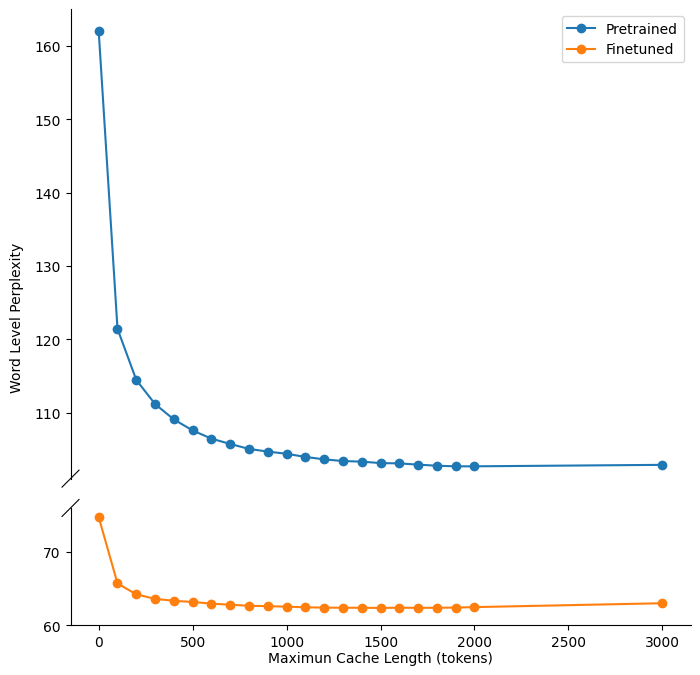

In [ ]:
#0 = 162.26
def sublinear(x):
    return np.log10(x+1)



fig = plt.figure(figsize=(8, 8))
ax = brokenaxes(ylims=((60,76), (101, 165)), hspace=.1)
# change scale to sub linear

#ax.set_xscale('function', functions=(sublinear, sublinear))


cache_length_p = [0,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000]
perplexity_p = [162,121.43, 114.46, 111.17, 109.07, 107.57, 106.45, 105.73, 105.05, 104.69, 104.39, 103.96, 103.63, 103.40, 103.32, 103.12, 103.08, 102.91, 102.76, 102.68, 102.68, 102.88]
cache_length_p = np.array(cache_length_p)
#cache_length_p = sublinear(cache_length_p)

perplexity_p = np.array(perplexity_p)
perplexity_p_second_moment =  (perplexity_p)
#perplexity_p = sublinear(perplexity_p)


ax.plot(cache_length_p, perplexity_p_second_moment, 'o-', label='Pretrained')

# log scale
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('perplexity_pretrained_ami.svg')
#plt.show()
#0 = 74.75
cache_length_f = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000]
cache_length_f = np.array(cache_length_f)
#cache_length_f = sublinear(cache_length_f)

perplexity_f = [74.75, 65.71, 64.22, 63.61,  63.34, 63.18, 62.96, 62.8, 62.67, 62.61, 62.54, 62.46, 62.41, 62.4, 62.39, 62.37, 62.40, 62.38, 62.39, 62.42, 62.48, 63.01]
perplexity_f = np.array(perplexity_f)
perplexity_f_second_moment = (perplexity_f)
#print(perplexity_f_diff)
#perplexity_f = sublinear(perplexity_f)


ax.plot(cache_length_f, perplexity_f_second_moment, 'o-', label='Finetuned')
ax.legend()
#fig.autofmt_xdate()
#plt.xlabel('Maximun Cache Length (tokens)')
#plt.ylabel('Word Level Perplexity')
#plt.savefig('perplexity_finetuned_ami.svg')

# axis labels
ax.set_xlabel('Maximun Cache Length (tokens)')
ax.set_ylabel('Word Level Perplexity')

plt.savefig('perplexity_ami.svg')
plt.show()


In [ ]:
perplexity_f_second_moment.shape

(22,)

In [ ]:
import tools

[NeMo W 2023-02-23 13:05:09 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-02-23 13:05:09 experimental:27] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [ ]:
!ls

beam_search.ipynb		   myopicdropout.ipynb
caching_test.ipynb		   nsp.ipynb
contrastive_rescoring.ipynb	   perplexity_finetuned_ami.svg
cross_attention_dynamic_pos.ipynb  perplexity_pretrained_ami.svg
frequency_attention.ipynb	   __pycache__
lm_utils.py			   qknorm_attention.py
log_probs.pkl			   Untitled-1.ipynb
lps.pkl				   Untitled-1__.ipynb
lps_s.pkl


In [ ]:
def get_words_and_time(sample):
    s,e = sample.supervisions[0].custom.values()
    duration = e - s
    text = sample.supervisions[0].text
    words = text.split()
    id = sample.supervisions[0].recording_id
    return len(words), duration, id

In [ ]:
from tqdm import tqdm
from tools import request_env

In [ ]:
AMI = tools.load_corpus(target_folder=request_env('AMI_PATH'), prefix_path=request_env('AMI_BASE'), file_name=request_env('AMI_NAME'))



In [ ]:
ids = {}
for sample in tqdm(AMI['train']):
    words, duration, id = get_words_and_time(sample)
    if id in ids:
        ids[id]['duration'] += duration
        ids[id]['words'] += words
    else:
        ids[id] = {'duration': duration, 'words': words}

total_words = 0
total_duration = 0
for id in ids:
    words, duration = ids[id]['words'], ids[id]['duration']
    total_words += words
    total_duration += duration
print(f'Words: {total_words}, Duration: {total_duration/60/60} hours, meetings: {len(ids)}')


100%|██████████| 85832/85832 [00:10<00:00, 8312.03it/s]

Words: 764088, Duration: 80.07895416666665 hours, meetings: 132


In [ ]:
ids.keys()

In [ ]:
ted['train'][0]

MonoCut(id='0f0b20c9-8713-4d26-a28a-e3c2c5c59ae8', start=0, duration=2.29, channel=0, supervisions=[SupervisionSegment(id='StevenStrogatz_2004R-0', recording_id='StevenStrogatz_2004R', start=0.0, duration=2.29, channel=0, text='just sideways about how much was it moving', language='English', speaker='StevenStrogatz_2004R', gender=None, custom={'segment_start': 1001.66, 'segment_end': 1003.95}, alignment=None)], features=None, recording=Recording(id='0f0b20c9-8713-4d26-a28a-e3c2c5c59ae8', sources=[AudioSource(type='file', channels=[0], source='/store/store1/data/TEDLIUM_release1/tedlium/wavs/train/0f0/0f0b20c9-8713-4d26-a28a-e3c2c5c59ae8.wav')], sampling_rate=16000, num_samples=36640, duration=2.29, transforms=None), custom=None)

In [ ]:
predictions,targets = [],[]
for item in tqdm(data):
    predictions.append(item['prediction'])
    targets.append(item['targets'][0])

100%|██████████| 10886/10886 [00:00<00:00, 352776.78it/s]


In [ ]:
from nemo.collections.asr.metrics.wer import word_error_rate

In [ ]:
word_error_rate(hypotheses=predictions, references=targets)

0.23168788139325183

In [ ]:
predictions

['',
 "it's not saved yet",
 'okay',
 'so',
 "'",
 'or beautiful drawing',
 'so just',
 "so this is our agenda you you're going to show your prototype presentation after me",
 'oops',
 '',
 "oh i didn't know he",
 'so these are the',
 'oh okay yeah',
 "so these are the last notes that are made if anything doesn't look right just say it to me and i don't have to put it in the report",
 "you know we're doing the speech recognition because we didn't have enough time to um design the inside as well",
 "okay but still possible uh uh financially so if you want to it's okay",
 "okay yeah but then then we're gonna put it in",
 'okay just',
 'yeah just so we have to design the inside then but it should be a',
 "or are we making a slide open like underneath or fall open i don't know",
 'slide open is quite useful for remote control',
 "it's probably better",
 'yes like underneath you can slide it open you can under functions',
 'maybe maybe a bit stronger as well',
 "maybe that's prob",
 'yeah',

In [ ]:
import time
from tqdm import tqdm

In [ ]:
a = []
times = []
cur_total = 0
for i in tqdm(range(10000000)):
    t1 = time.time()
    a += [i] + [i]
    t2 = time.time()
    cur_total += t2-t1
    if i % 10000 == 0:
        times.append(cur_total)
        cur_total = 0

100%|██████████| 10000000/10000000 [00:13<00:00, 743159.17it/s]


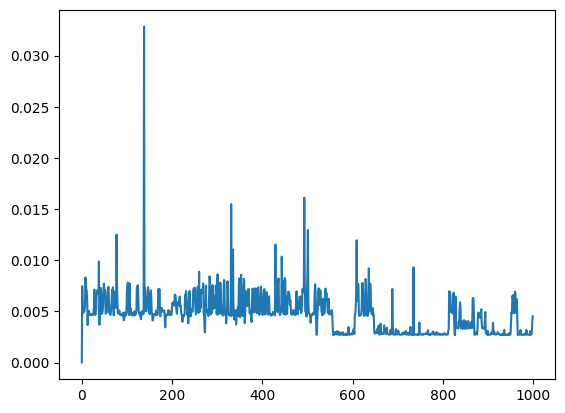

In [ ]:

times = np.array(times)

plt.plot(times)

In [ ]:
import torch

In [ ]:
a = torch.randn(1000)*10

In [18]:
def EMA(a, alpha=0.99):
    b = a.clone()
    for i in range(1, len(a)):
        b[i] = alpha * b[i-1] + (1-alpha) * a[i]
    return b
    

In [19]:
b = EMA(a)

In [20]:
import matplotlib.pyplot as plt

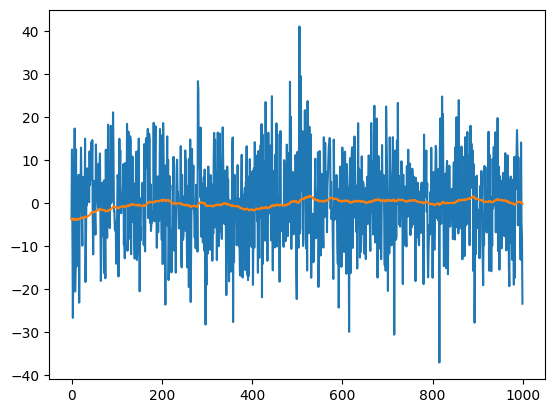

In [21]:
plt.plot(a)
plt.plot(b)


In [1]:
!ls

beam_search.ipynb		   myopicdropout.ipynb
caching_test.ipynb		   nsp.ipynb
contrastive_rescoring.ipynb	   perplexity_ami.svg
cross_attention_dynamic_pos.ipynb  perplexity_finetuned_ami.svg
frequency_attention.ipynb	   perplexity_pretrained_ami.svg
lm_utils.py			   __pycache__
log_probs.pkl			   qknorm_attention.py
lps.pkl				   Untitled-1.ipynb
lps_s.pkl			   Untitled-1__.ipynb


In [3]:
%cd tedlium

/exp/exp1/acp21rjf/deliberation/speachy/tedlium


In [166]:
!ls *.pkl

logprobs.pkl  WadeDavis_2003_1000_tkns.pkl  WadeDavis_2003.pkl
pred_tst.pkl  WadeDavis_2003_50.pkl


In [5]:
import pickle as pkl

In [167]:
with open('WadeDavis_2003.pkl', 'rb') as f:
    data_0 = pkl.load(f)

In [22]:
import torch

In [168]:
idx = 0
past_lm_scores_0 = data_0['beams'][idx].past_lm_scores
past_lm_scores_0 = torch.stack([el.cpu() for el in past_lm_scores_0])
past_lm_scores_0 = past_lm_scores_0.to(torch.float64)

In [136]:
idx = 0
past_lm_scores_50 = data_50['beams'][idx].past_lm_scores
past_lm_scores_50 = torch.stack([el.cpu() for el in past_lm_scores_50])
past_lm_scores_50 = past_lm_scores_50.to(torch.float64)

In [137]:
idx = 0
past_lm_scores = data['beams'][idx].past_lm_scores
past_lm_scores = torch.stack([el.cpu() for el in past_lm_scores])
past_lm_scores = past_lm_scores.to(torch.float64)

In [91]:
torch.float64

torch.float64

In [93]:
import matplotlib.pyplot as plt

In [223]:
def EMAscore(a, alpha=0.9):
    b = a.clone()
    for i in range(1, len(a)):
        b[i] = alpha * b[i-1] + (1-alpha) * a[i]
    return b

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [260]:
def moving_statistics(a, window=100):
    '''standardises a based on the mean and std of the previous window elements'''
    b = a.clone()
    for i in range(1, len(a)):
        b[i] = (a[i] - a[max(0,i-window):i].mean()) / a[max(0,i-window):i].std()
    return b
    


In [180]:
import numpy as np

In [ ]:
plt.plo

In [280]:
moving_statistics(past_lm_scores, 10)

tensor([-2.5195,     nan,  2.0098,  ...,  0.6972,  0.5663,  0.4829],
       dtype=torch.float64)

In [259]:
past_lm_scores.shape

torch.Size([12206])

In [227]:
past_lm_scores_0.mean()

tensor(-1.3048, dtype=torch.float64)

In [255]:
moving_std_0 = moving_std(past_lm_scores_0, n=100)
moving_std_1000 = moving_std(past_lm_scores, n=100)
moving_average_0 = moving_average(past_lm_scores_0, n=100)
moving_average_1000 = moving_average(past_lm_scores, n=100)

moving_standardised_0 = (past_lm_scores_0 / moving_std_0) - moving_average_0
plt.show()

RuntimeError: The size of tensor a (12202) must match the size of tensor b (12004) at non-singleton dimension 0

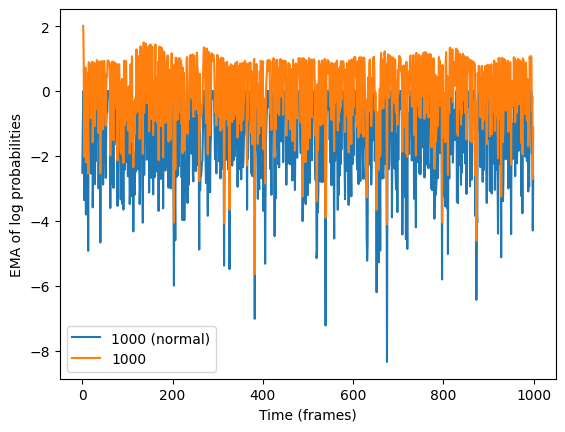

In [277]:
until = 1000
#plt.plot(past_lm_scores[:until])
'''plt.plot(EMAscore(past_lm_scores)[:until], label='1000')
#plt.plot(EMAscore(past_lm_scores_50)[:until], label='50')
plt.plot(EMAscore(past_lm_scores_0)[:until], label='0')'''
plt.plot(past_lm_scores[:until], label='1000 (normal)')
#plt.plot(past_lm_scores_0[:until], label='50 (normal)')

plt.plot(moving_statistics(past_lm_scores[:until], window=50), label='1000')
#plt.plot(moving_statistics(past_lm_scores_0[:until]), label='50')

plt.legend()
plt.xlabel('Time (frames)')
plt.ylabel('EMA of log probabilities')
plt.show()

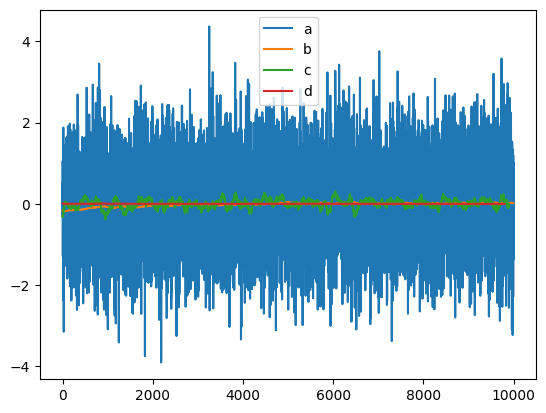

In [247]:
a = torch.randn(10000)
b=  EMAscore(a, 0.999)
c = moving_average(a, n=100)
d = moving_std(a, n=100)
plt.plot(a, label='a')
plt.plot(b, label='b')
plt.plot(c, label='c')
plt.plot(d, label='d')
plt.legend()